# SyriaTel Customer Churn

   Natalia Edelson
   
   Flatiron School, Project_3
  
   Instructor, Claude Fried 


#### Importing Libraries

In [283]:
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import f1_score,precision_score,recall_score,plot_confusion_matrix,plot_roc_curve,classification_report
global model_auc, model_ll, model_roc_auc
import warnings
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')
import time
import seaborn as sns
%matplotlib inline
from xgboost import XGBClassifier

In [284]:
# Import the data and look into the different columns.
Customer_Churn = pd.read_csv('Churn.csv')

Customer_Churn.head()



,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


### Exploring and cleaning the data 
* Check data types
* Check for null values
* Check for duplicates
* Check for imbalance of churn True vs False
* Check for outlier


In [285]:
# Column Names: Replacing space with underscore 
new_columns = [i.replace(' ', '_') for i in Customer_Churn.columns]
Customer_Churn.columns = new_columns


In [286]:
# Check for null values
null_counts = Customer_Churn.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts))

Number of null values in each column:
state                     0
account_length            0
area_code                 0
phone_number              0
international_plan        0
voice_mail_plan           0
number_vmail_messages     0
total_day_minutes         0
total_day_calls           0
total_day_charge          0
total_eve_minutes         0
total_eve_calls           0
total_eve_charge          0
total_night_minutes       0
total_night_calls         0
total_night_charge        0
total_intl_minutes        0
total_intl_calls          0
total_intl_charge         0
customer_service_calls    0
churn                     0
dtype: int64


In [287]:

#Distribution of data type
print("Data types and their frequency\n{}".format(Customer_Churn.dtypes.value_counts()))

Data types and their frequency
float64    8
int64      8
object     4
bool       1
dtype: int64


In [288]:
# Check for duplicates
Customer_Churn.duplicated().sum()

0

In [289]:
# Check balance of target data 
Customer_Churn['churn'].value_counts()

False    2850
True      483
Name: churn, dtype: int64

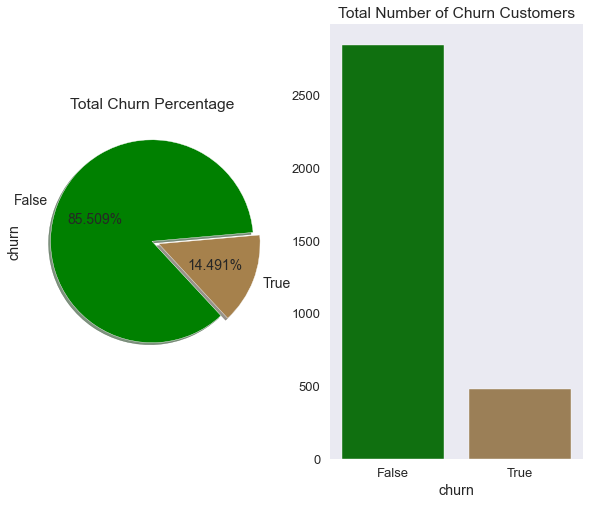

In [290]:
# Data to plot
plt.style.use(['seaborn-dark','seaborn-talk'])

fig, ax = plt.subplots(1,2,figsize=(10,8))

Customer_Churn['churn'].value_counts().plot.pie(explode=[0,0.07], ax=ax[0], autopct='%1.3f%%', shadow=True, 
                                    fontsize=14, startangle=5, colors=["#008000", "#a6814c"])
ax[0].set_title('Total Churn Percentage')

sns.countplot('churn', data=Customer_Churn, ax=ax[1], palette=["#008000", "#a6814c"])
ax[1].set_title('Total Number of Churn Customers')
ax[1].set_ylabel('      ')

plt.show()

We can see that the data is not balanced: 85% of people are not churning. We need to keep it in mind when building our models and see whether we need to use any tools to balance the data.  

In [291]:
# Explore the dataset's stats and check for outliers 
display(Customer_Churn.describe())


,account_length,area_code,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


There are no outliers.

### Converting Categorical variables to dummy ones

1. state             - object 
2. international_plan       - object 
3. voice_mail_plan          - object 
4. churn                    - bool   




In [292]:

conditions = [
    Customer_Churn['international_plan'] == 'no',
    Customer_Churn['international_plan'] == 'yes'
]

choices = [
    0,
    1,
]

Customer_Churn['international_plan'] = np.select(conditions, choices)


conditions = [
    Customer_Churn['voice_mail_plan'] == 'no',
    Customer_Churn['voice_mail_plan'] == 'yes'
]

choices = [
    0,
    1,
]

Customer_Churn['voice_mail_plan'] = np.select(conditions, choices)




conditions = [
    Customer_Churn.churn == True,
    Customer_Churn.churn == False
]

choices = [
    1,
    0,
]

Customer_Churn.churn = np.select(conditions, choices)

Customer_Churn.head()


,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,KS,128,415,382-4657,0,1,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,371-7191,0,1,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,358-1921,0,0,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,375-9999,1,0,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,330-6626,1,0,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [293]:
# Cleaning and exploring relationships 
Customer_Churn.phone_number

0       382-4657
1       371-7191
2       358-1921
3       375-9999
4       330-6626
          ...   
3328    414-4276
3329    370-3271
3330    328-8230
3331    364-6381
3332    400-4344
Name: phone_number, Length: 3333, dtype: object

In [294]:
Customer_Churn.area_code.unique()

array([415, 408, 510])

### Dropping columns that are not useful. 

There are only three types of area codes which clearly does not represent the real population given the distribution of costumer’s states. Also, the six digits of the phone number will not give us any useful information to predict churning. Therefore, we will drop both the  “area_codes” and “phone_number” columns.

In [295]:
Customer_Churn.drop('area_code', axis = 1, inplace = True)
Customer_Churn.drop('phone_number', axis = 1, inplace = True)

In [296]:
# Dheck that the drop function worked

Customer_Churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account_length          3333 non-null   int64  
 2   international_plan      3333 non-null   int64  
 3   voice_mail_plan         3333 non-null   int64  
 4   number_vmail_messages   3333 non-null   int64  
 5   total_day_minutes       3333 non-null   float64
 6   total_day_calls         3333 non-null   int64  
 7   total_day_charge        3333 non-null   float64
 8   total_eve_minutes       3333 non-null   float64
 9   total_eve_calls         3333 non-null   int64  
 10  total_eve_charge        3333 non-null   float64
 11  total_night_minutes     3333 non-null   float64
 12  total_night_calls       3333 non-null   int64  
 13  total_night_charge      3333 non-null   float64
 14  total_intl_minutes      3333 non-null   

## Exploring States


We investigate the states churning data. We want to see whether there are any states that show more churning than others. 

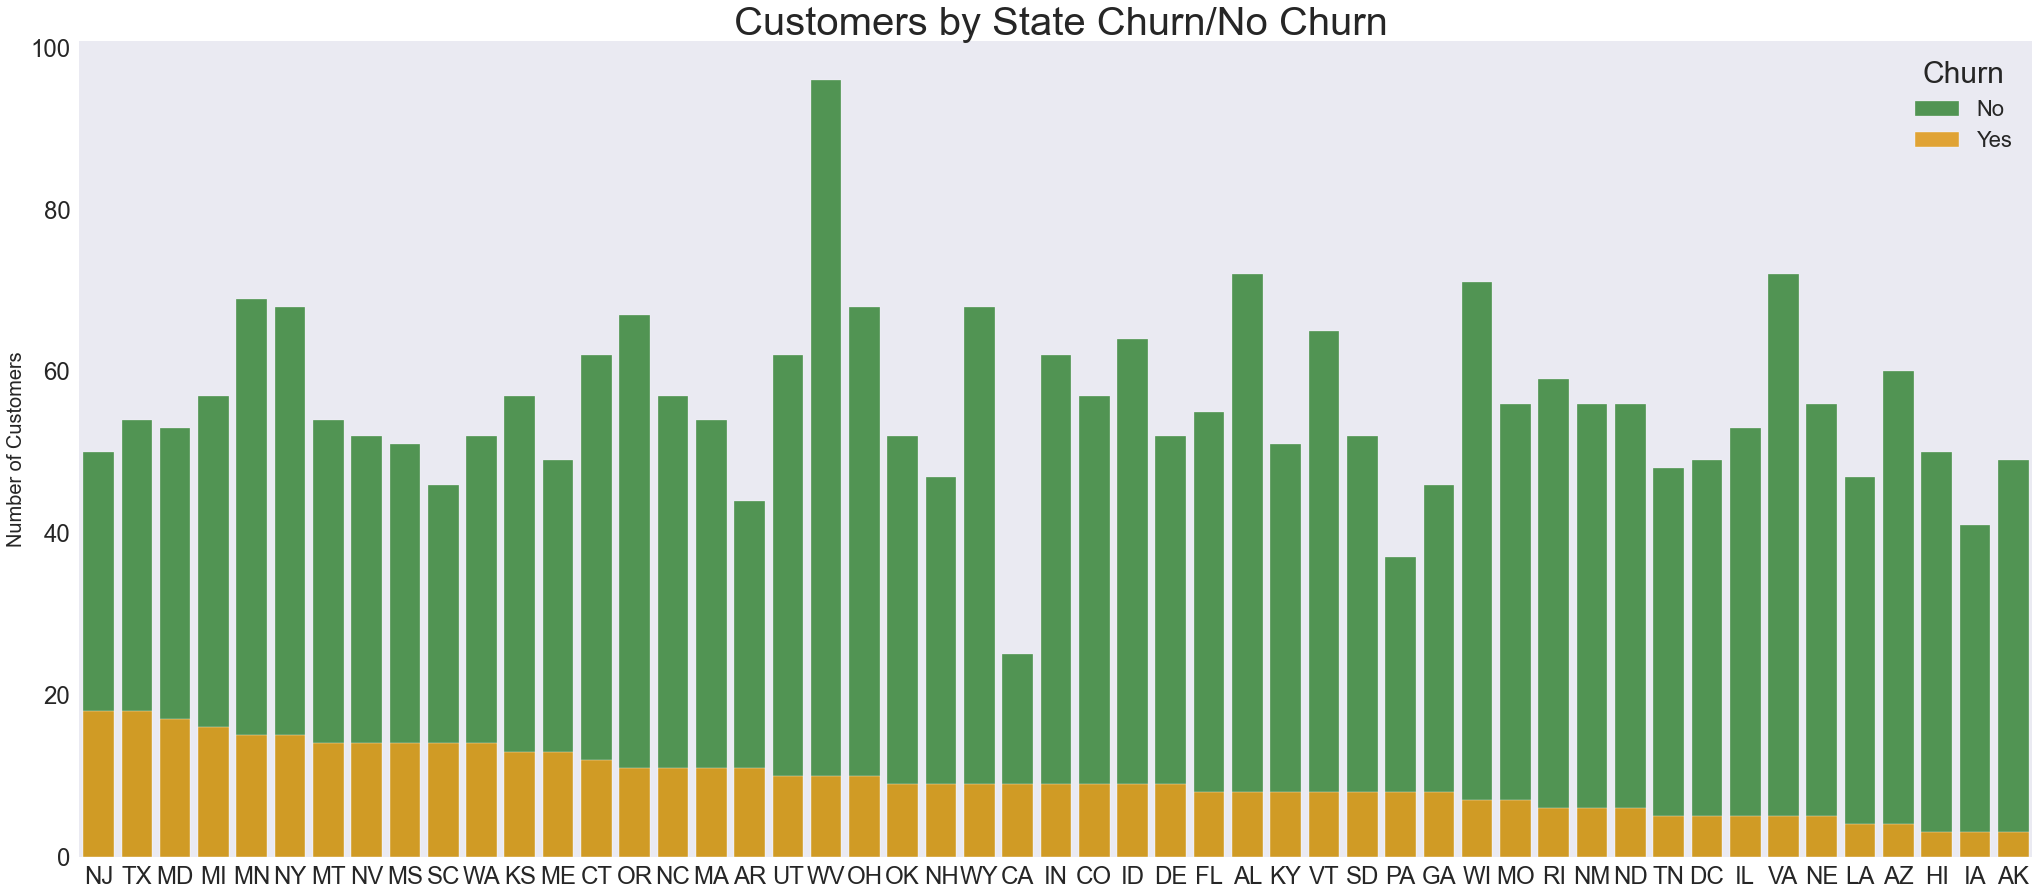

In [297]:
states_plot = Customer_Churn.pivot_table(index='state', columns='churn', values='account_length', aggfunc='count').reset_index()
states_plot.columns = ['state', 'false', 'true']
states_plot = states_plot.sort_values('true', ascending=False).reset_index(drop=True)

# Plot
plt.figure(figsize=(35,15))

# Two bar charts
s1 = sns.barplot(x = 'state', y = 'false', data = states_plot, color = 'green', alpha=0.7, label='No')
s2 = sns.barplot(x = 'state', y = 'true', data = states_plot, color = 'orange', alpha=0.9, label='Yes')

# Title, labels and legend
plt.savefig('output.png')
plt.title(' Customers by State Churn/No Churn', size=40)
plt.ylabel('Number of Customers', size=20)
plt.xlabel(None)
plt.legend(title='Churn', prop={'size': 22}, title_fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show();

In [298]:
top_states =states_plot.head(6)
top_states 

,state,false,true
0,NJ,50,18
1,TX,54,18
2,MD,53,17
3,MI,57,16
4,MN,69,15
5,NY,68,15


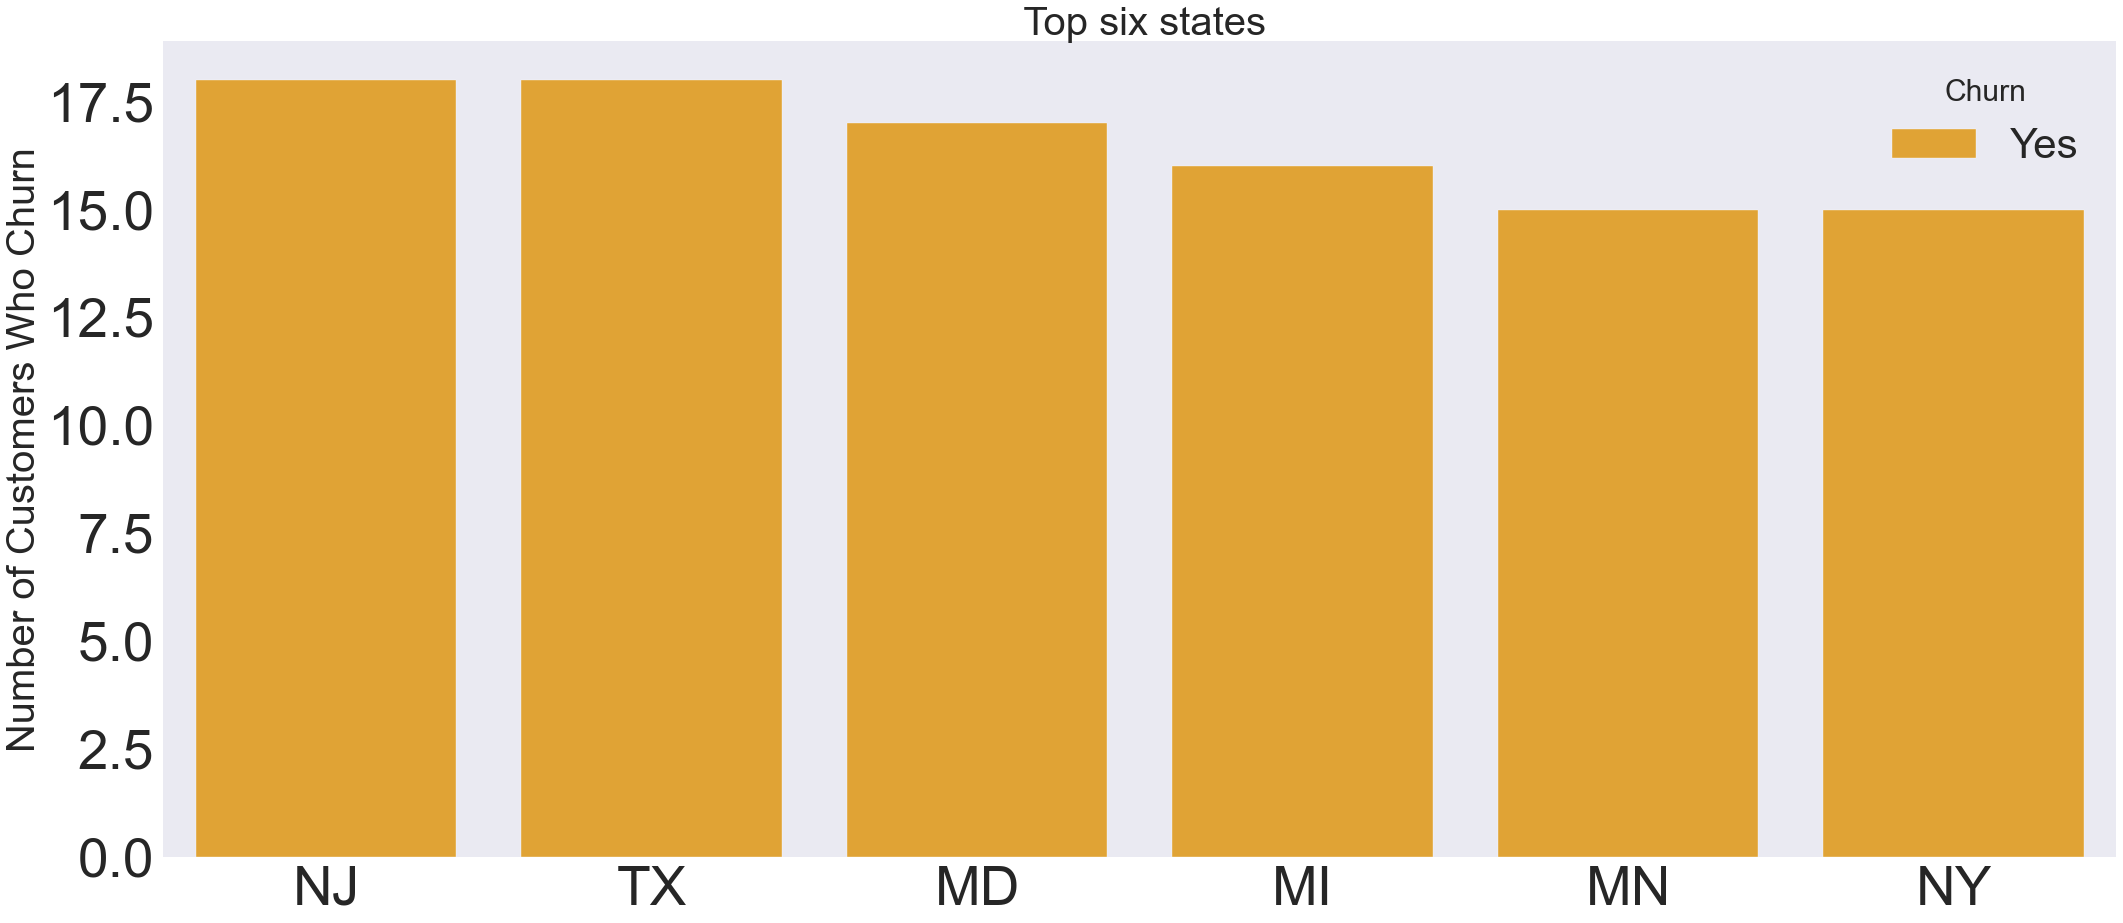

<Figure size 748.8x514.8 with 0 Axes>

In [299]:
plt.figure(figsize=(35,15))

# Two bar charts
S1 = sns.barplot(x = 'state', y = 'true', data = top_states, color = 'orange', alpha=0.9, label='Yes')

# Title, labels and legend
plt.savefig('output.png')
plt.title(' Top six states', size=40)
plt.ylabel('Number of Customers Who Churn', size=40)
plt.xlabel(None)
plt.legend(title='Churn', prop={'size': 42}, title_fontsize=30)
plt.xticks(fontsize=55)
plt.yticks(fontsize=55)
plt.show()
plt.savefig('Top 6 States.pdf')

Check the average churn of the highest states versus the average of all the states.

In [300]:
states_plot.true.mean()

9.470588235294118

In [301]:
top_states.true.mean()

16.5

The states above were the six highest. It will be useful for the company to have these states flagged in order decide whether there are cost effective methods to refrain them from leaving. 

In [302]:
#Below we are checking the correlation between variables and we will examine the ones that show strong correlation. 

Text(0.5, 1.0, ' Costumer Churn Variables - Correlation Matric Hat Map ')

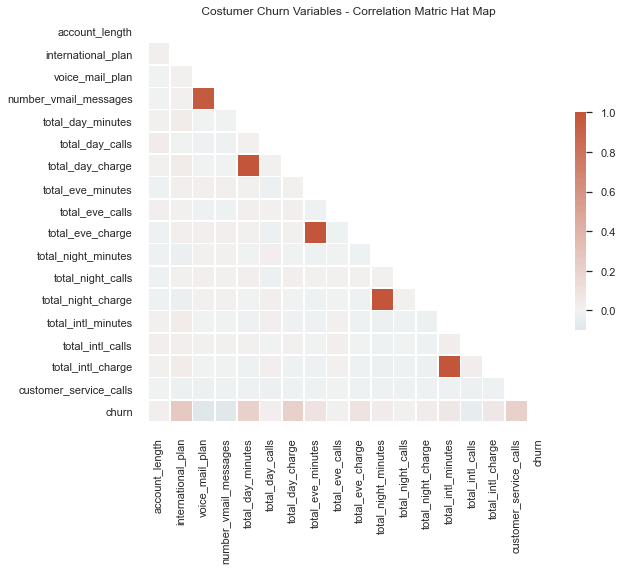

In [303]:
sns.set(style="white")

corr = Customer_Churn.corr().round(2)

mask = np.triu(np.ones_like(corr, dtype=bool))
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(9, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title(' Costumer Churn Variables - Correlation Matric Hat Map ')

In [304]:
(abs(Customer_Churn.corr()) > 0.85).sum()


account_length            1
international_plan        1
voice_mail_plan           2
number_vmail_messages     2
total_day_minutes         2
total_day_calls           1
total_day_charge          2
total_eve_minutes         2
total_eve_calls           1
total_eve_charge          2
total_night_minutes       2
total_night_calls         1
total_night_charge        2
total_intl_minutes        2
total_intl_calls          1
total_intl_charge         2
customer_service_calls    1
churn                     1
dtype: int64


#### The variables below are naturally perfectly correlated and therefore provide redundant information. We can exclude the minutes and will leave the charges. 



total_day_minutes & total_day_charge          
total_eve_minutes & total_eve_charge          


In [305]:
Customer_Churn.drop('total_day_minutes', axis = 1, inplace = True)
Customer_Churn.drop('total_eve_minutes', axis = 1, inplace = True)



We will look closely into the variables that show a higher correlation to churn.

 - total_day_charge
 - total_eve_charge 
 - customer_service_calls 

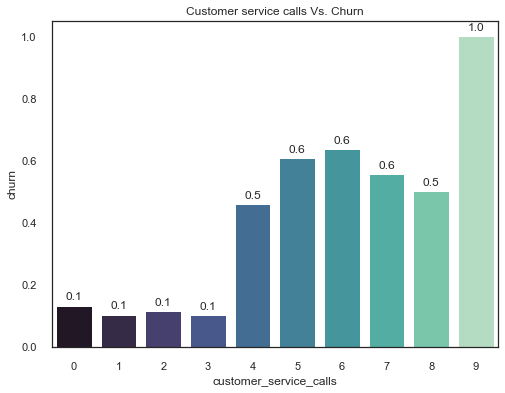

In [306]:
plt.figure(figsize=(8, 6))
splot = sns.barplot(x='customer_service_calls', y='churn',
                    data=Customer_Churn, palette='mako', ci=None)



for p in splot.patches:
    
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.title('Customer service calls Vs. Churn')
plt.show()





We can clearly see that the higher customer service call will likely lead to a customer leaving. Especially after 3 calls we saw an increase in churning. We would recommend investing in the costumer service assistance. 


We visualize the data to clearly see where the data rests. Let's use boxplot to visualize the evening and day charge.  Using a box and whisker plot, allows us to see how the data is distributed and whether it is concentrated in a certain area.

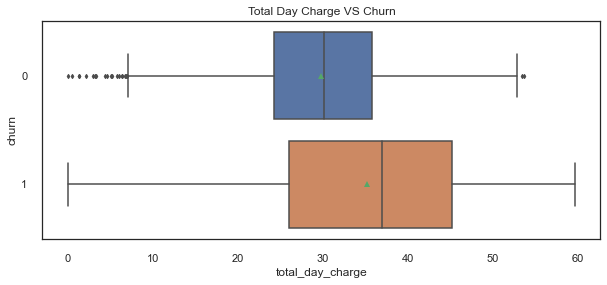

point biserial correlation r is 0.20515074317015378 with p = 5.300605952400049e-33


In [307]:
# We would need to visualize the data to clearly see where the data rests. Let's use boxplot to visualize the evening and day charge :
from scipy import stats, linalg

fig, ax = plt.subplots(figsize=(10,4))

sns.boxplot(y = Customer_Churn['churn'], x = Customer_Churn['total_day_charge'],width = 0.8,orient = 'h', showmeans = True, fliersize = 3, ax = ax)
plt.title('Total Day Charge VS Churn')
plt.show()

# Calculate the correlation coefficient
r, p = stats.pointbiserialr(Customer_Churn['churn'], Customer_Churn['total_day_charge'])
print ('point biserial correlation r is %s with p = %s' %(r,p))


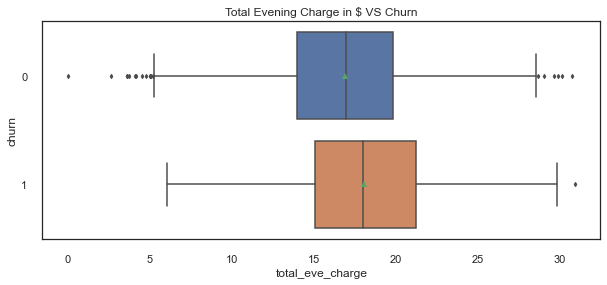

point biserial correlation r is 0.09278603942871362 with p = 8.03652422776417e-08


In [308]:
fig, ax = plt.subplots(figsize=(10,4))

sns.boxplot(y = Customer_Churn['churn'], x = Customer_Churn['total_eve_charge'],width = 0.8,orient = 'h', showmeans = True, fliersize = 3, ax = ax)
plt.title('Total Evening Charge in $ VS Churn')
plt.show()

# Calculate the correlation coefficient
r, p = stats.pointbiserialr(Customer_Churn['churn'], Customer_Churn['total_eve_charge'])
print ('point biserial correlation r is %s with p = %s' %(r,p))



### Account Length

We check whether costumers leave in a certain time and whether staying longer had any relationship to churning. 

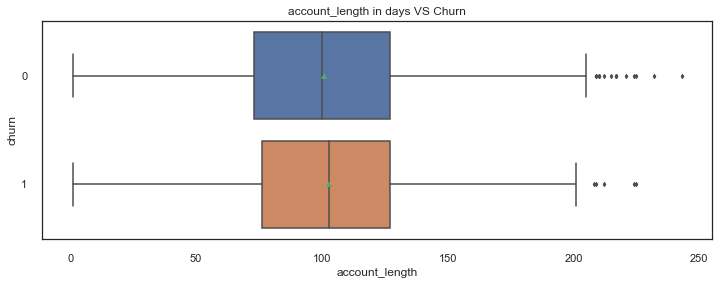

point biserial correlation r is 0.01654074224367413 with p = 0.33976000705592885


In [309]:
fig, ax = plt.subplots(figsize=(12,4))

sns.boxplot(y = Customer_Churn['churn'], x = Customer_Churn['account_length'],width = 0.8,orient = 'h', showmeans = True, fliersize = 3, ax = ax)
plt.title('account_length in days VS Churn')
plt.show()

# Calculate the correlation coefficient
r, p = stats.pointbiserialr(Customer_Churn['churn'], Customer_Churn['account_length'])
print ('point biserial correlation r is %s with p = %s' %(r,p))

The account length data is normally distributed and the majority of the account stays from 60 days to 150.


Text(0.5, 1.0, 'Account Length in Days')

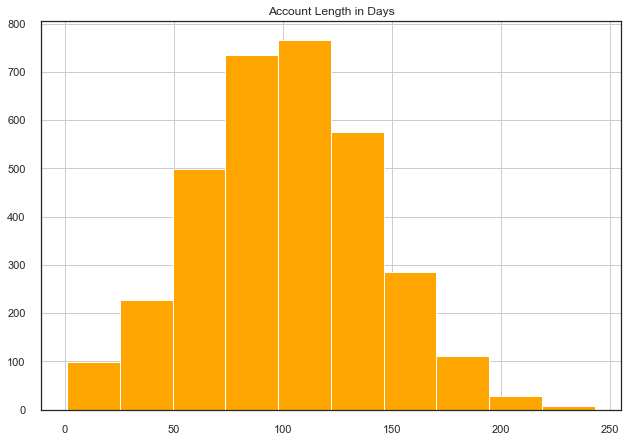

In [310]:
import seaborn as sns

AL_Plot= Customer_Churn.account_length.hist(color="orange", label="accountlength")
plt.title('Account Length in Days')


The length of the accounts is normally distributed. 

In [311]:
states_dummies = pd.get_dummies(Customer_Churn["state"], prefix="STATES")
Customer_Churn = pd.concat([Customer_Churn, states_dummies], axis = 1)
Customer_Churn.head()

,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_calls,total_day_charge,total_eve_calls,total_eve_charge,total_night_minutes,...,STATES_SD,STATES_TN,STATES_TX,STATES_UT,STATES_VA,STATES_VT,STATES_WA,STATES_WI,STATES_WV,STATES_WY
0,KS,128,0,1,25,110,45.07,99,16.78,244.7,...,0,0,0,0,0,0,0,0,0,0
1,OH,107,0,1,26,123,27.47,103,16.62,254.4,...,0,0,0,0,0,0,0,0,0,0
2,NJ,137,0,0,0,114,41.38,110,10.30,162.6,...,0,0,0,0,0,0,0,0,0,0
3,OH,84,1,0,0,71,50.90,88,5.26,196.9,...,0,0,0,0,0,0,0,0,0,0
4,OK,75,1,0,0,113,28.34,122,12.61,186.9,...,0,0,0,0,0,0,0,0,0,0


### Converting states into dummy variables

We convert the states into dummy variables in order for the model to be able work with the states data. 


In [312]:
Customer_Churn.drop('state', axis =1, inplace=True)

In [313]:
Customer_Churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 67 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account_length          3333 non-null   int64  
 1   international_plan      3333 non-null   int64  
 2   voice_mail_plan         3333 non-null   int64  
 3   number_vmail_messages   3333 non-null   int64  
 4   total_day_calls         3333 non-null   int64  
 5   total_day_charge        3333 non-null   float64
 6   total_eve_calls         3333 non-null   int64  
 7   total_eve_charge        3333 non-null   float64
 8   total_night_minutes     3333 non-null   float64
 9   total_night_calls       3333 non-null   int64  
 10  total_night_charge      3333 non-null   float64
 11  total_intl_minutes      3333 non-null   float64
 12  total_intl_calls        3333 non-null   int64  
 13  total_intl_charge       3333 non-null   float64
 14  customer_service_calls  3333 non-null   

In [314]:
Customer_Churn.head()

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_calls,total_day_charge,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,...,STATES_SD,STATES_TN,STATES_TX,STATES_UT,STATES_VA,STATES_VT,STATES_WA,STATES_WI,STATES_WV,STATES_WY
0,128,0,1,25,110,45.07,99,16.78,244.7,91,...,0,0,0,0,0,0,0,0,0,0
1,107,0,1,26,123,27.47,103,16.62,254.4,103,...,0,0,0,0,0,0,0,0,0,0
2,137,0,0,0,114,41.38,110,10.30,162.6,104,...,0,0,0,0,0,0,0,0,0,0
3,84,1,0,0,71,50.90,88,5.26,196.9,89,...,0,0,0,0,0,0,0,0,0,0
4,75,1,0,0,113,28.34,122,12.61,186.9,121,...,0,0,0,0,0,0,0,0,0,0


In [315]:
# Scaling 
#account_length = Customer_Churn.account_length 

#scaled_account_length = (account_length - np.mean(account_length))/np.sqrt(np.var(account_length))


#Customer_Churn = pd.concat([Customer_Churn, scaled_account_length], axis = 1)




### Labeling  

#### Creating features, labels, training, and test data

Creating features, labels, training, and test data

In [316]:
#  We create X and y by selecting 'churn' from the dataset and then we create a 80/20 split on the dataset for training/test. Use random_state=10 for reproducibility
X = Customer_Churn.drop('churn', axis=1)  
y = Customer_Churn['churn'] 

### Train and Test Splits

We create X and y by selecting 'churn' from the dataset and then we create an 80/20 split on the dataset for training/test. We use random_state=10  to achieve reproducible results.




In [317]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)

In [318]:
#check that the split worked.
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((2666, 66), (2666,), (667, 66), (667,))

### Scaling

We are scaling the data using the Standard Scaler method. Standardize the data by making the mean of the distribution  zero and the majority of the data will be between -1 and 1.

In [319]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)



#### Scaling all the data to perform Cross Validation Score

In [320]:
# We are going to scale the original X and Y data in order to use the cross validation score


X_scaler = StandardScaler()
    
X_scaler.fit(X)
    
X_scaled = pd.DataFrame(X_scaler.transform(X), columns=X.columns)



### Buiding Models

We create a function that would later look through the model classifiers and calculate the various scores to evaluate each model.

We chose to run the following classifiers for our data: 

Logistic Regression
K-Nearest Neighbor 
Decision Tree model
XGboost



In [321]:
def Train_Test_Scores(model):
    
    model.fit(X_train_scaled,y_train)
    
    print('Train_Accuracy:', model.score(X_train_scaled,y_train))
    print('Test_Accuracy:', model.score(X_test_scaled,y_test))
    print('Recall:', recall_score(y_test,model.predict(X_test_scaled),average='micro'))
    print('Precision:',recall_score(y_test,model.predict(X_test_scaled),average='micro'))
    print('F1_Score:',recall_score(y_test,model.predict(X_test_scaled),average='micro'))



### Logisic Regression Model


We will run the model regularly and then tune logistic regression as well.

Given the unbalance data of SyriaTel, we use class_weight=’balanced’) method for our Logistic Regression model. This will give weight to both the majority and minority variables. 


In [322]:
LogReg =(LogisticRegression(solver='lbfgs', class_weight='balanced'))
Train_Test_Scores(LogReg)

Train_Accuracy: 0.7790697674418605
Test_Accuracy: 0.782608695652174
Recall: 0.782608695652174
Precision: 0.782608695652174
F1_Score: 0.782608695652174


### KNN Model with SMOTE

#### We will use SMOTE for as our data as unbalanced. 



In [323]:
# Previous original class distribution
from imblearn.over_sampling import SMOTE
print(y_train.value_counts()) 

# Fit SMOTE to training data
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train) 

# Preview synthetic sample class distribution
print('\n')

print(pd.Series(y_train_resampled).value_counts()) 

0    2278
1     388
Name: churn, dtype: int64


1    2278
0    2278
Name: churn, dtype: int64


In [324]:
knn = KNeighborsClassifier() 

knn.fit(X_train_resampled,y_train_resampled)
    
print('Train_Accuracy:', knn.score(X_train_resampled,y_train_resampled))
print('Test_Accuracy:', knn.score(X_test_scaled,y_test))
print('Recall:', recall_score(y_test,knn.predict(X_test_scaled)))
print('Precision:',recall_score(y_test,knn.predict(X_test_scaled)))
print('F1_Score:',recall_score(y_test,knn.predict(X_test_scaled)))
print('mean_CV_recall:', np.mean(cross_val_score(knn, X_scaled, y, scoring="recall", cv = 5)))




Train_Accuracy: 0.8781826163301142
Test_Accuracy: 0.8575712143928036
Recall: 0.0
Precision: 0.0
F1_Score: 0.0
mean_CV_recall: 0.0413659793814433


### KNN Model and GridSearchCV, Hyperparameters: 
We tune the KNN model using GridSearchCV and it finds the optimal parameters.

In [325]:
param_grid = {
     'n_neighbors': list(range(1, 20, 2)),
     'weights': ['uniform','distance'],
     'metric': ['euclidean', 'manhattan'],
 }

gs_knn = GridSearchCV(knn, param_grid=param_grid, cv=5)
gs_knn.fit(X_train_scaled, y_train)

gs_knn.best_params_

{'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}

In [326]:
best_knn = KNeighborsClassifier(n_neighbors = 13,
                                metric = 'euclidean',
                                weights = 'uniform') 

best_knn.fit(X_train_resampled,y_train_resampled)

print('Train_Accuracy:', best_knn.score(X_train_resampled,y_train_resampled))
print('Test_Accuracy:', best_knn.score(X_test_scaled,y_test))
print('Recall:', recall_score(y_test,best_knn.predict(X_test_scaled),average='micro'))
print('Precision:',recall_score(y_test,best_knn.predict(X_test_scaled),average='micro'))
print('F1_Score:',recall_score(y_test,best_knn.predict(X_test_scaled),average='micro'))
print('mean_CV_recall:', np.mean(cross_val_score(best_knn, X_scaled, y, scoring="recall", cv = 5)))

Train_Accuracy: 0.7978489903424056
Test_Accuracy: 0.8575712143928036
Recall: 0.8575712143928036
Precision: 0.8575712143928036
F1_Score: 0.8575712143928036
mean_CV_recall: 0.0020833333333333333


In [327]:
y_test.value_counts(normalize=True)

0    0.857571
1    0.142429
Name: churn, dtype: float64

### Decision Tree Model

In [328]:
DT_clf = DecisionTreeClassifier()
Train_Test_Scores(DT_clf)

Train_Accuracy: 1.0
Test_Accuracy: 0.9325337331334332
Recall: 0.9325337331334332
Precision: 0.9325337331334332
F1_Score: 0.9325337331334332


### Hyperparameter Tuning and Pruning in Decision Tree

We will tune our Decision Tree classifier in order to avoid overfitting and hopefully achieve better results with our prediction.

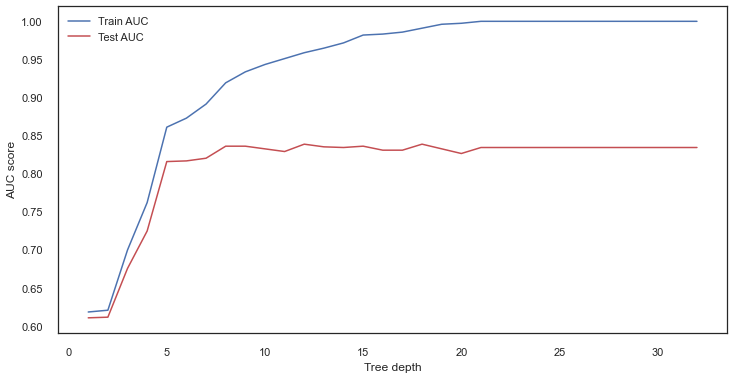

In [329]:
#Maximum Tree Depth

max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   DT = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=1)
   DT.fit(X_train, y_train)
   train_pred = DT.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)


   # Adding AUC score to previous train results
   train_results.append(roc_auc)
   y_pred = DT.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(max_depths, train_results, 'b', label='Train AUC')
plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.legend()
plt.show()




In [330]:
# Optimum Value of max_debth is 3  - Training and test errors rise rapidly between the depths of 2 and 3

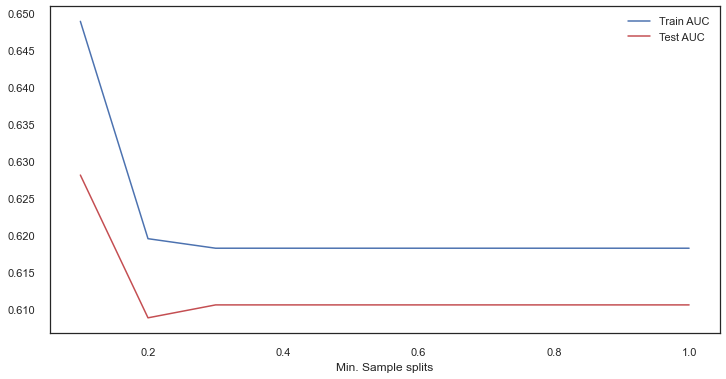

In [331]:
# Minimun Split

min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   DT = DecisionTreeClassifier(criterion='entropy', min_samples_split=min_samples_split, random_state=1)
   DT.fit(X_train, y_train)
   train_pred = DT.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = DT.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.xlabel('Min. Sample splits')
plt.legend()
plt.show()




In [332]:
# AUC for both test and train data plateaued  at 0.2 
# Further increase in minimum sample split does not improve learning 

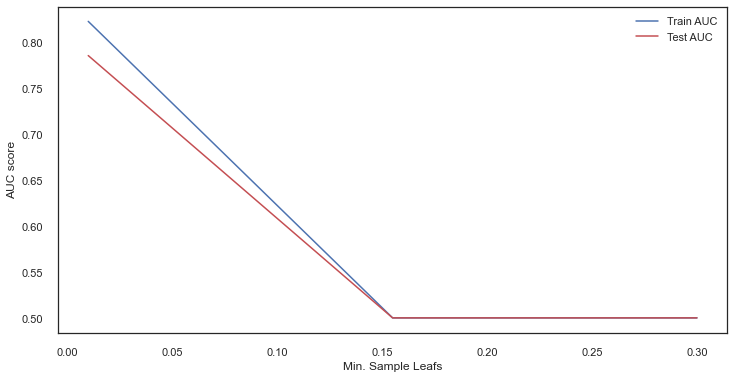

In [333]:
#Minimum Sample Leafs

min_samples_leafs = np.linspace(0.01, 0.3, 3, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   DT = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=min_samples_leaf, random_state=1)
   DT.fit(X_train, y_train)
   train_pred = DT.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = DT.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    
plt.figure(figsize=(12,6))    
plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Min. Sample Leafs')
plt.legend()
plt.show()

In [334]:
# AUC gives best value between 0.01


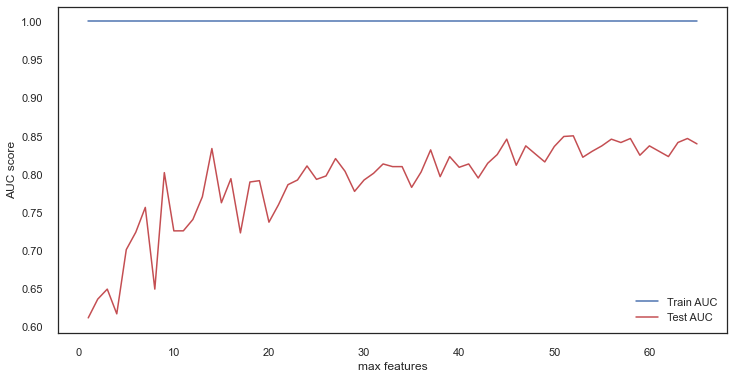

In [335]:
# Find the best value for optimal maximum feature size
max_features = list(range(1, X_train.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
   DT = DecisionTreeClassifier(criterion='entropy', max_features=max_feature, random_state=1)
   DT.fit(X_train, y_train)
   train_pred = DT.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = DT.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(max_features, train_results, 'b', label='Train AUC')
plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.legend()

In [336]:
# No  effect on the training dataset - flat AUC 
# Highest AUC value seen at 0.86

In [337]:

# Train a classifier with optimal values we identified 
dt_h_tuning = DecisionTreeClassifier(criterion='entropy',
                           max_features=0.86,
                           max_depth=10,
                           min_samples_split=0.001,
                           min_samples_leaf=0.0001, 
                           random_state=1)
dt_h_tuning.fit(X_train_scaled, y_train)
y_pred = dt_h_tuning.predict(X_test_scaled)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8421420684578579

In [338]:
# The improvement of the hyper parameter was not significant

In [339]:
Train_Test_Scores(dt_h_tuning)

Train_Accuracy: 0.9831207801950488
Test_Accuracy: 0.9400299850074962
Recall: 0.9400299850074962
Precision: 0.9400299850074962
F1_Score: 0.9400299850074962


In [340]:
dt_h_tuning.score(X_train_scaled, y_train)

0.9831207801950488

### XGboost Model

In [341]:
XGboost_model= XGBClassifier()

In [342]:
Train_Test_Scores(XGboost_model)

Train_Accuracy: 1.0
Test_Accuracy: 0.9610194902548725
Recall: 0.9610194902548725
Precision: 0.9610194902548725
F1_Score: 0.9610194902548725


### Tuning XGBoost W

We will also tune our XGboost model by applying GrisSearchCV to obtain ultimate values and we will set up restrictions for the search using “param_grid” for the purpose of time efficiency.

In [343]:
param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
    'verbosity': [0]
     
}


In [344]:
grid_clf = GridSearchCV(XGboost_model, param_grid, scoring='accuracy', cv=None, n_jobs=1)


best_parameters = grid_clf.param_grid

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s`: %r' % (param_name, best_parameters[param_name]))



Grid Search found the following optimal parameters: 
learning_rate`: [0.1, 0.2]
max_depth`: [6]
min_child_weight`: [1, 2]
n_estimators`: [100]
subsample`: [0.5, 0.7]
verbosity`: [0]


In [345]:
Train_Test_Scores(grid_clf) 

Train_Accuracy: 0.9827456864216054
Test_Accuracy: 0.9625187406296851
Recall: 0.9625187406296851
Precision: 0.9625187406296851
F1_Score: 0.9625187406296851


In [346]:
ALLmodels = [LogReg,knn,best_knn,DT_clf,dt_h_tuning,XGboost_model,grid_clf]


model_names = 'Logistic_reg KNN KNN_tuned Decision_Tree Decision_Tree_tuned XGboost XGboost_Tuned'.split()

models_DataFrame = pd.DataFrame(columns=['Model','Train_Accuracy','Test_Accuracy','Precision','Recall','F1_score','Mean_CV','Mean_CV_Recall'])

for (model,model_names) in zip(ALLmodels,model_names):
    
    print(model_names)
    
    model.fit(X_train_scaled, y_train)
    
    y_preds = model.predict(X_test_scaled)
    
    Train_Accuracy = model.score(X_train_scaled,y_train)
    Test_Accuracy = model.score(X_test_scaled,y_test)
    Precision = precision_score(y_test,y_preds)
    Recall = recall_score(y_test,y_preds)
    f1_Score = f1_score(y_test,y_preds)
    
    mean_cv_recall = np.mean(cross_val_score(model, X_scaled, y, scoring="recall", cv = 5))
    
    mean_cv = np.mean(cross_val_score(model, X_scaled, y, cv = 5))

    report = classification_report(y_test, y_preds)

    print(report)
    
    models_DataFrame  = models_DataFrame.append({'Model':model_names,'Train_Accuracy':Train_Accuracy,'Test_Accuracy':Test_Accuracy,'Precision':Precision,'Recall':Recall,'F1_score':f1_Score,'Mean_CV':mean_cv,'Mean_CV_Recall':mean_cv_recall}, ignore_index=True)
    

Logistic_reg
              precision    recall  f1-score   support

           0       0.95      0.79      0.86       572
           1       0.37      0.74      0.49        95

    accuracy                           0.78       667
   macro avg       0.66      0.76      0.68       667
weighted avg       0.87      0.78      0.81       667

KNN
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       572
           1       0.62      0.05      0.10        95

    accuracy                           0.86       667
   macro avg       0.74      0.52      0.51       667
weighted avg       0.83      0.86      0.81       667

KNN_tuned
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       572
           1       0.00      0.00      0.00        95

    accuracy                           0.86       667
   macro avg       0.43      0.50      0.46       667
weighted avg       0.74      0.86      0.79    

In [347]:
models_DataFrame 

,Model,Train_Accuracy,Test_Accuracy,Precision,Recall,F1_score,Mean_CV,Mean_CV_Recall
0,Logistic_reg,0.779070,0.782609,0.368421,0.736842,0.491228,0.759079,0.724850
1,KNN,0.870593,0.860570,0.625000,0.052632,0.097087,0.852983,0.041366
2,KNN_tuned,0.857839,0.857571,0.000000,0.000000,0.000000,0.855086,0.002083
3,Decision_Tree,1.000000,0.925037,0.736842,0.736842,0.736842,0.921692,0.728780
4,Decision_Tree_tuned,0.983121,0.940030,0.848101,0.705263,0.770115,0.932193,0.697680
5,XGboost,1.000000,0.961019,0.948052,0.768421,0.848837,0.954996,0.759772
6,XGboost_Tuned,0.982746,0.962519,0.948718,0.778947,0.855491,0.956197,0.751525


#### Comparing Models

We compare the scores below for all the models. Our main focus will be to look into Recall because we will not want to miss a false negative. If the costumer left and we miss that data, it can be very costly for SyriaTel. We have more tolerance for precision because in the worst case scenario, we would offer a costumer whom we think left but didn’t leave, some incentive which will hopefully increase his likelihood to stay with the company.  


XGboost has showed to have the highest Ave Cross validation score. We will dig into the feature importance to get further details. 


In [348]:

AvgCrossValRecall = models_DataFrame["Mean_CV_Recall"]
max_value = AvgCrossValRecall.max()
print(max_value)

0.7597723367697593


In [349]:
x_plot = models_DataFrame["Model"]
y_plot = models_DataFrame["Mean_CV_Recall"]

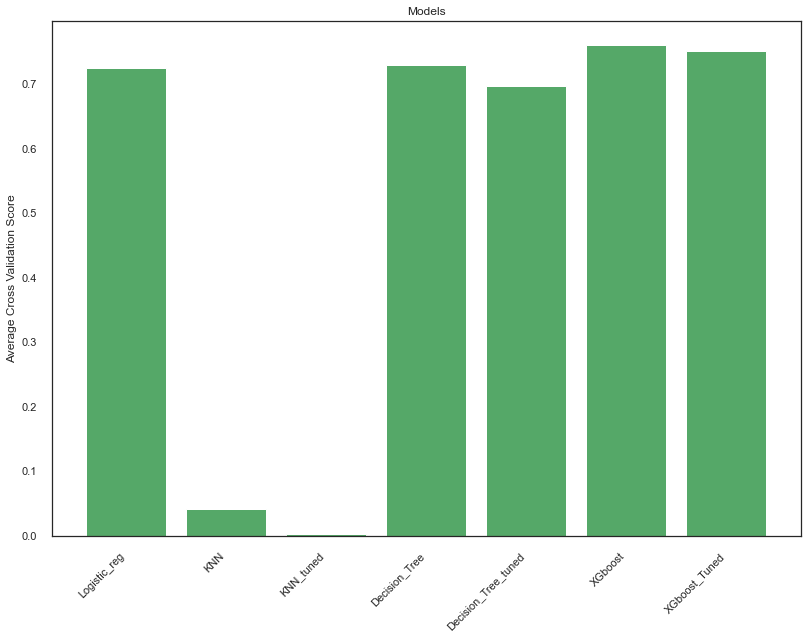

In [350]:

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x_plot,y_plot, color ='g')
plt.xticks(rotation=45, ha="right")
ax.set_ylabel('Average Cross Validation Score')
ax.set_title('Models')
plt.show()



#### Receiver Operating Characteristic ("ROC")

ROC Curve presents the trade-off among the true positive rate and false positive rate for the XGBoost model using different probability thresholds. 

XGBoost:  AUC=0.904


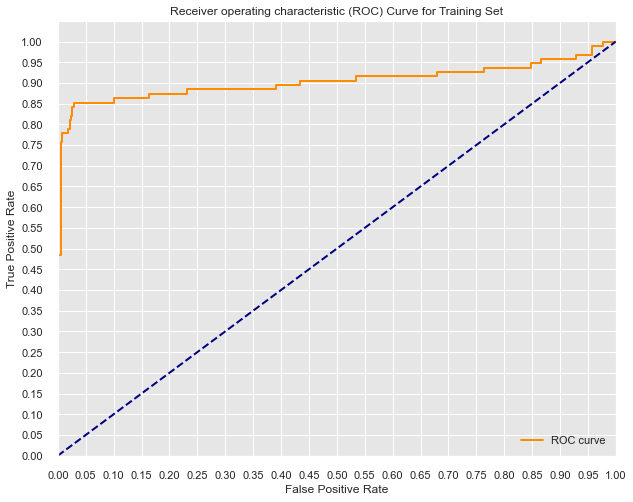

In [386]:
# generate a no skill prediction (majority class)
from matplotlib import pyplot
import matplotlib.pyplot as plt
%matplotlib inline

ns_probs = [0 for _ in range(len(y_test))]

#fir XG Boost

XGboost_model= XGBClassifier()

XGboost_model.fit(X_train_scaled, y_train)


# predict probabilities
XG_probs = XGboost_model.predict_proba(X_test_scaled)


# keep probabilities for the positive outcome only
XG_probs = XG_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
XG_auc = roc_auc_score(y_test, XG_probs)


# summarize scores


print('XGBoost:  AUC=%.3f' % (XG_auc))



# calculate roc curves
XG_fpr, XG_tpr, _ = roc_curve(y_test, XG_probs)


# ROC curve for training set
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(XG_fpr, XG_tpr, color='darkorange',
         lw=lw, label='ROC curve')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Training Set')
plt.legend(loc='lower right')


#### Precision-Recall Curve ("PRC")


We also show the precision-recall curve as it is more appropriate for imbalanced data that we are dealing with. We can see in the graph the trade-off among the true positive and the predictive positive value for our XGboost model using various probability thresholds.
As we mentioned above, we are more focused on having a higher recall without giving up too much on precision. Roughly around 90%, precision is a little north of 80% and this is a feasible trade-off for our model.


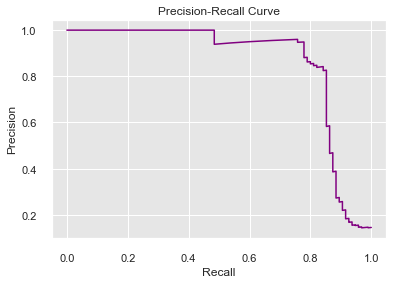

In [396]:
precision, recall, thresholds = precision_recall_curve(y_test, XG_probs)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

#### PRC

We also show the precision-recall curve as it is more appropriate for imbalanced data that we are dealing with. We can see in the graph the trade-off among the true positive and the predictive positive value for our XGboost model using various probability thresholds.

As we mentioned above, we are more focused on having a higher recall without giving up too much on precision. Roughly around 90%, precision is a little north of 80% and this is a feasible trade-off for our model. 


In [387]:

def plot_feature_importances(model):
    n_features = X_train_scaled.shape[1]
    plt.figure(figsize=(12,26))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train_scaled.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

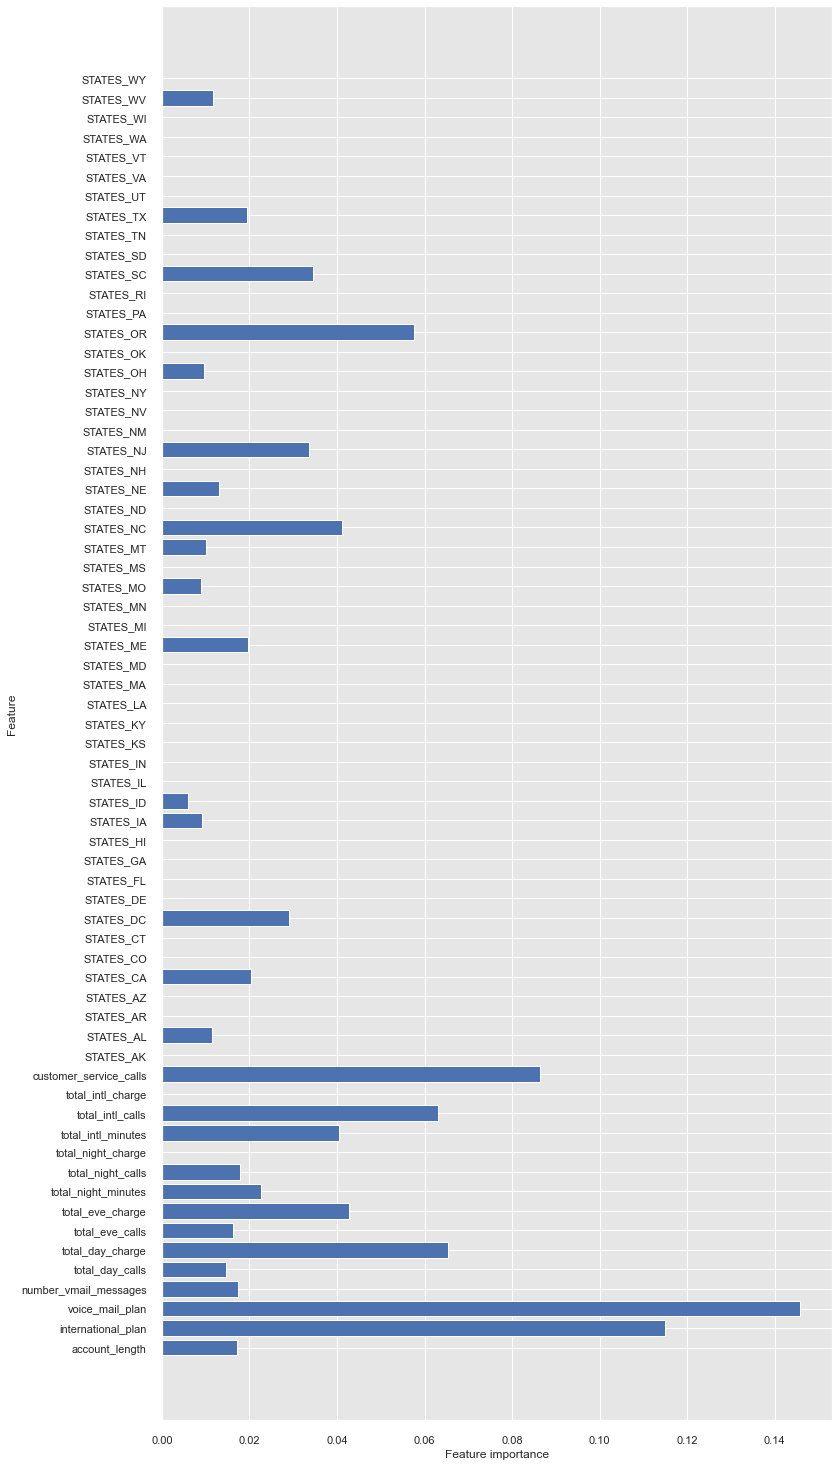

In [388]:
plot_feature_importances(XGboost_model)

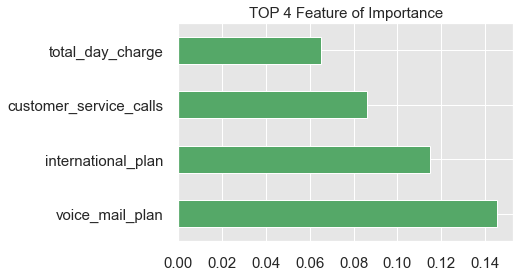

In [389]:
model_1 = XGboost_model

(pd.Series(model_1.feature_importances_, index=X.columns)
   .nlargest(4)
   .plot(kind='barh',color='g'))    
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('TOP 4 Feature of Importance',fontsize=15)
fig.savefig('TOP_4.jpg')

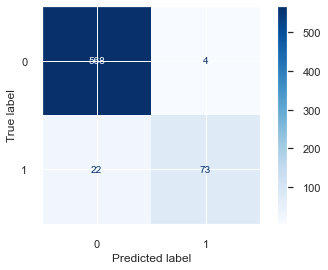

In [390]:
plot_confusion_matrix(XGboost_model, X_test_scaled, y_test, cmap="Blues")

### Voicemail Plan 


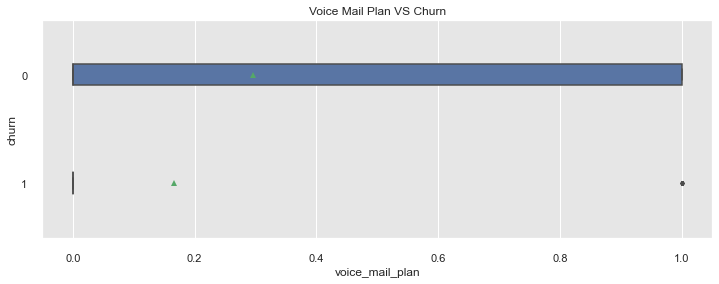

point biserial correlation r is -0.10214814067014703 with p = 3.4110371159402205e-09


In [391]:
# We would need to visualize the data to clearly see where the data rests. Let's use boxplot to visualize the evening and day charge :
from scipy import stats, linalg

fig, ax = plt.subplots(figsize=(12,4))

sns.boxplot(y = Customer_Churn['churn'], x = Customer_Churn['voice_mail_plan'],width = 0.2,orient = 'h', showmeans = True, fliersize = 3, ax = ax)
plt.title('Voice Mail Plan VS Churn')
plt.show()

# Calculate the correlation coefficient
r, p = stats.pointbiserialr(Customer_Churn['churn'], Customer_Churn['voice_mail_plan'])
print ('point biserial correlation r is %s with p = %s' %(r,p))

In [392]:
Customer_Churn['churn'].corr(Customer_Churn['voice_mail_plan'])

-0.10214814067014703

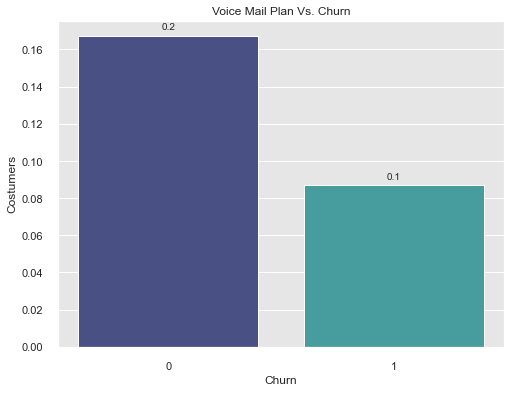

In [393]:
plt.figure(figsize=(8, 6))
splot = sns.barplot(x='voice_mail_plan', y='churn',
                    data=Customer_Churn, palette='mako', ci=None)


for p in splot.patches:
    
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.title('Voice Mail Plan Vs. Churn')

#plt.legend(title='Churn', prop={'size': 12}, title_fontsize=30)


#plt.figure(figsize=(12,6))

plt.plot()
plt.plot()

plt.ylabel('Costumers')
plt.xlabel('Churn')

plt.show()

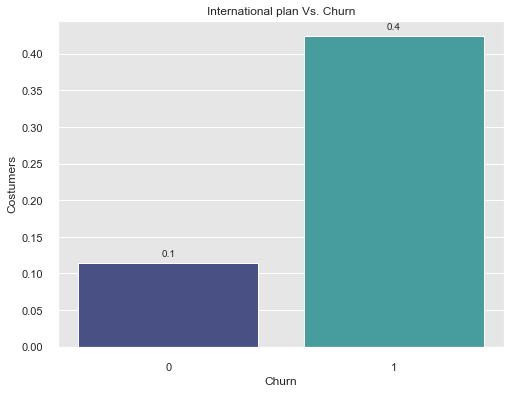

In [394]:
plt.figure(figsize=(8, 6))
splot = sns.barplot(x='international_plan', y='churn',
                    data=Customer_Churn, palette='mako', ci=None)


for p in splot.patches:
    
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.title('International plan Vs. Churn')

#plt.legend(title='Churn', prop={'size': 12}, title_fontsize=30)


#plt.figure(figsize=(12,6))

plt.plot()
plt.plot()

plt.ylabel('Costumers')
plt.xlabel('Churn')

plt.show()

### Features of Importance


#### Voicemail Plan
We found a voicemail plan stood out as one of the most important features. As seen in the graph, people with a voicemail plan are twice as less likely to churn. 

Therefore, we recommend offering voicemail plans to customers who do not have them as part of the incentives used to retain customers. Perhaps when a customer calls the second or third time, SyrianTel can offer them a voicemail plan as a promotion if they don’t currently have one. 

International Plan
An international plan was also an important feature. Customers who had an international plan were four times as likely to churn. This is an element SyriaTel should focus on. Perhaps they could consider eliminating this specific plan and offer one reoccurring plan for all. 


As expected, Customer Service calls were shown to be an important feature. As we see above, customers are five times more likely to churn after the third call. This supports our suggestion of offering an incentive to stay after the second and third call. SyriaTel can offer three weeks free of charge before subscribing for a year or as mentioned above, gift a customer a voicemail plan for three weeks as well. 


#### States

In addition to the states mentioned above, Oregon (OR) should be flagged, as it came out to be an important feature.  Customer Service should be aware of the states that customers are calling from. We recommend exploring the possibility of partnering with other companies. For instance – if a customer from Oregon calls the second time and already has a voicemail plan, one incentive could be to offer a gift from another vendor such as Uber EATS – e.g. a $10 credit to order food which might incentivize the client to stay. 


#### Next Step

- We would like to gather more data on the specific dates of churning. Ideally, we would be able to look at an individual account and learn the dates of a company subscribing and subsequently leaving. 

- Allowing us to look closely into customer satisfaction could be useful by offering a survey once a Customer Service call is complete. Perhaps also closely examining how long a customer waited before his request was satisfied would be beneficial. 

- We will examine whether a flat fee per month would be more cost-effective than a reoccurring monthly charge with a certain number of minutes. 

- Additionally, we would like to consider using a different vendor or temporally partnering to offer incentives and promotions when a customer seems dissatisfied may increase satisfaction and reduce churning.

- Ultimately, we will implement the new features to see whether churning was reduced and calculate the cost of retaining the customers. 
















Thank you 😀